In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib2
% matplotlib inline

In [3]:
date = "150808" ## LATER: update to pull most recent week or take an argument
url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_" + date + ".txt"
data = urllib2.urlopen(url)
df = pd.read_csv(data)

In [4]:
df.head()

## it works!!

C/A  UNIT       SCP        STATION LINENAME DIVISION        DATE  \
0  A002  R051  02-00-00  LEXINGTON AVE   NQR456      BMT  08/01/2015   
1  A002  R051  02-00-00  LEXINGTON AVE   NQR456      BMT  08/01/2015   
2  A002  R051  02-00-00  LEXINGTON AVE   NQR456      BMT  08/01/2015   
3  A002  R051  02-00-00  LEXINGTON AVE   NQR456      BMT  08/01/2015   
4  A002  R051  02-00-00  LEXINGTON AVE   NQR456      BMT  08/01/2015   

       TIME     DESC  ENTRIES  \
0  00:00:00  REGULAR  5249369   
1  04:00:00  REGULAR  5249393   
2  08:00:00  REGULAR  5249415   
3  12:00:00  REGULAR  5249519   
4  16:00:00  REGULAR  5249751   

   EXITS                                                                 
0                                            1775966                     
1                                            1775968                     
2                                            1775987                     
3                                            1776069                     
4                                            1776111

In [5]:
## check for irregular rows

irreg = sum(df.DESC != "REGULAR")

recoverd = sum(df.DESC == "RECOVR AUD")

## verify that all irregular rows are "recovered audits"
assert(irreg == recoverd)

In [6]:
## filter out PATH trains (DIVISION = "PTH")
lenbefore = len(df)
df2 = df[df.DIVISION != "PTH"]
lenafter = len(df2)

assert(lenbefore > lenafter)
assert(sum(df2.DIVISION == "PTH") == 0)
df = df2

In [7]:
## aggregate by station (we don't care about individual devices)
##  while preserving date/time data

## GROUP_BY station, linename, date, time AGGREGATE entries, exits BY sum
aggdf = df.groupby(["STATION","LINENAME","DATE","TIME"]).sum()
aggdf.head(100)
## some stations share a name, but no stations on the same line share a name, thus use of both STATION and LINENAME
##  (some stations also have multiple UNITs)

ENTRIES  \
STATION LINENAME DATE       TIME                   
1 AVE   L        08/01/2015 00:00:00  1404469489   
                            04:00:00  1404471670   
                            08:00:00  1404472343   
                            12:00:00  1404475276   
                            16:00:00  1404480057   
                            20:00:00  1404484778   
                 08/02/2015 00:00:00  1404488579   
                            04:00:00  1404490267   
                            08:00:00  1404490794   
                            12:00:00  1404493120   
                            16:00:00  1404496916   
                            20:00:00  1404500584   
                 08/03/2015 00:00:00  1404503304   
                            04:00:00  1404503858   
                            08:00:00  1404505629   
                            12:00:00  1404510784   
                            16:00:00  1404514302   
                            20:00:00  1404520569   
                 08/04/2015 00:00:00  1404524191   
                            04:00:00  1404524862   
                            08:00:00  1404526624   
                            12:00:00  1404531697   
                            16:00:00  1404535600   
                            20:00:00  1404542171   
                 08/05/2015 00:00:00  1404546371   
                            04:00:00  1404547193   
                            08:00:00  1404548971   
                            12:00:00  1404554367   
                            16:00:00  1404558426   
                            20:00:00  1404565044   
...                                          ...   
103 ST  1        08/05/2015 17:00:00    61883358   
                            21:00:00    61886083   
                 08/06/2015 01:00:00    61886965   
                            05:00:00    61887033   
                            09:00:00    50062150   
                            13:00:00    61893264   
                            17:00:00    61895942   
                            21:00:00    61898781   
                 08/07/2015 01:00:00    61899804   
                            05:00:00    61899873   
                            09:00:00    61902507   
                            13:00:00    61905714   
                            17:00:00    61908393   
                            21:00:00    61911097   
        6        08/01/2015 01:00:00    37022891   
                            05:00:00    37023002   
                            09:00:00    37023551   
                            13:00:00    37024717   
                            17:00:00    37025988   
                            21:00:00    37026969   
                 08/02/2015 01:00:00    37027473   
                            05:00:00    37027578   
                            09:00:00    37027993   
                            13:00:00    37028763   
                            17:00:00    37029782   
                            21:00:00    37030668   
                 08/03/2015 01:00:00    37031009   
                            05:00:00    37031087   
                            09:00:00    37032363   
                            13:00:00    37033766   

                                      EXITS                                                                 
STATION LINENAME DATE       TIME                                                                            
1 AVE   L        08/01/2015 00:00:00                                         1465927127                     
                            04:00:00                                         1465928311                     
                            08:00:00                                         1465929324                     
                            12:00:00                                         1465931908                     
                            16:00:00                                         1465935943                     
 

In [77]:
## some rows are missing -- 103rd St 1 line 8/6/2015 at 9:00am reading missing.
##  how do we identify more such rows?
##    after subtracting prv row value, these rows should be the only ones with negative values
##  how do we fix them?
##    a. remove row entirely (won't someone PLEASE think of the DATA!!)
##    b. interpolate (split the diff btwn next and previous rows) (ideal, but futzier)
##    c. subtract cumulative totals before agg'ing (missing entries will accrue to next row) (easier to implement)

## subtract previous row values for all entries and exits to get total during period
agg = df.groupby(["UNIT", "SCP", "STATION","LINENAME"])
obj = pd.DataFrame()
for name, group in agg:
    #print name
    group = group.reset_index(drop=True)
    #print group.values[0]
    nc_ent = [0]
    nc_ext = [0]
    for i in range(1,len(group)):
        nc_ent.append(group.values[i][9]-group.values[i-1][9])
        nc_ext.append(group.values[i][10]-group.values[i-1][10])
    out = pd.concat([group,
                     pd.Series(nc_ent,name="NC_ENTRIES"),
                     pd.Series(nc_ext,name="NC_EXITS")], axis=1)
    obj = pd.concat([obj,out],ignore_index=True)

In [78]:

## Check for negative values

obj[obj.NC_ENTRIES < 0]

C/A  UNIT       SCP      STATION LINENAME DIVISION        DATE  \
2185    J034  R007  00-00-02       104 ST       JZ      BMT  08/01/2015   
2186    J034  R007  00-00-02       104 ST       JZ      BMT  08/01/2015   
2187    J034  R007  00-00-02       104 ST       JZ      BMT  08/01/2015   
2188    J034  R007  00-00-02       104 ST       JZ      BMT  08/01/2015   
2189    J034  R007  00-00-02       104 ST       JZ      BMT  08/01/2015   
2190    J034  R007  00-00-02       104 ST       JZ      BMT  08/02/2015   
2191    J034  R007  00-00-02       104 ST       JZ      BMT  08/02/2015   
2192    J034  R007  00-00-02       104 ST       JZ      BMT  08/02/2015   
2193    J034  R007  00-00-02       104 ST       JZ      BMT  08/02/2015   
2194    J034  R007  00-00-02       104 ST       JZ      BMT  08/02/2015   
2195    J034  R007  00-00-02       104 ST       JZ      BMT  08/02/2015   
2196    J034  R007  00-00-02       104 ST       JZ      BMT  08/03/2015   
2198    J034  R007  00-00-02       104 ST       JZ      BMT  08/03/2015   
2199    J034  R007  00-00-02       104 ST       JZ      BMT  08/03/2015   
2200    J034  R007  00-00-02       104 ST       JZ      BMT  08/03/2015   
2201    J034  R007  00-00-02       104 ST       JZ      BMT  08/03/2015   
2202    J034  R007  00-00-02       104 ST       JZ      BMT  08/04/2015   
2203    J034  R007  00-00-02       104 ST       JZ      BMT  08/04/2015   
2204    J034  R007  00-00-02       104 ST       JZ      BMT  08/04/2015   
2205    J034  R007  00-00-02       104 ST       JZ      BMT  08/04/2015   
2206    J034  R007  00-00-02       104 ST       JZ      BMT  08/04/2015   
2207    J034  R007  00-00-02       104 ST       JZ      BMT  08/04/2015   
2208    J034  R007  00-00-02       104 ST       JZ      BMT  08/05/2015   
2209    J034  R007  00-00-02       104 ST       JZ      BMT  08/05/2015   
2210    J034  R007  00-00-02       104 ST       JZ      BMT  08/05/2015   
2211    J034  R007  00-00-02       104 ST       JZ      BMT  08/05/2015   
2212    J034  R007  00-00-02       104 ST       JZ      BMT  08/05/2015   
2213    J034  R007  00-00-02       104 ST       JZ      BMT  08/05/2015   
2214    J034  R007  00-00-02       104 ST       JZ      BMT  08/06/2015   
2215    J034  R007  00-00-02       104 ST       JZ      BMT  08/06/2015   
...      ...   ...       ...          ...      ...      ...         ...   
174969  N508  R453  00-00-02  23 ST-6 AVE       FM      IND  08/03/2015   
174970  N508  R453  00-00-02  23 ST-6 AVE       FM      IND  08/03/2015   
174971  N508  R453  00-00-02  23 ST-6 AVE       FM      IND  08/03/2015   
174972  N508  R453  00-00-02  23 ST-6 AVE       FM      IND  08/03/2015   
174973  N508  R453  00-00-02  23 ST-6 AVE       FM      IND  08/03/2015   
174974  N508  R453  00-00-02  23 ST-6 AVE       FM      IND  08/04/2015   
174975  N508  R453  00-00-02  23 ST-6 AVE       FM      IND  08/04/2015   
174976  N508  R453  00-00-02  23 ST-6 AVE       FM      IND  08/04/2015   
174977  N508  R453  00-00-02  23 ST-6 AVE       FM      IND  08/04/2015   
174978  N508  R453  00-00-02  23 ST-6 AVE       FM      IND  08/04/2015   
174979  N508  R453  00-00-02  23 ST-6 AVE       FM      IND  08/04/2015   
174980  N508  R453  00-00-02  23 ST-6 AVE       FM      IND  08/05/2015   
174981  N508  R453  00-00-02  23 ST-6 AVE       FM      IND  08/05/2015   
174982  N508  R453  00-00-02  23 ST-6 AVE       FM      IND  08/05/2015   
174983  N508  R453  00-00-02  23 ST-6 AVE       FM      IND  08/05/2015   
174984  N508  R453  00-00-02  23 ST-6 AVE       FM      IND  08/05/2015   
174985  N508  R453  00-00-02  23 ST-6 AVE       FM      IND  08/05/2015   
174986  N508  R453  00-00-02  23 ST-6 AVE       FM      IND  08/06/2015   
174987  N508  R453  00-00-02  23 ST-6 AVE       FM      IND  08/06/2015   
174988  N508  R453  00-00-02  23 ST-6 AVE       FM      IND  08/06/2015   
174989  N508  R453  00-00-02  23 ST-6 AVE       FM      IND  08/06/2015   
174990  N508  R453  00-00-02  23 S

In [79]:
print sum(obj.NC_ENTRIES < 0)
print sum(obj.NC_ENTRIES < 0) / 42 ## 7 days * 6 collections per day = 42 entries for each device

## Several of the devices appear to be counting down rather than up. (1145 total negative records; ~ 27 devices)
##  It could be that their data is completely erroneous but I find that unlikely given that
##  the magnitudes in the daily patterns they report are sync with other (non-faulty) devices.
## Solutions?
##  a. identify each such device and multiply their figures by -1 (differences should remain constant)
##  b. remove from dataset entirely (my precious data!)
##  c. take absolute value for all entries

## solution C
##  assumes that all devices malfunctioned in the same, acceptable way. simply counting down instead of up.
##  if there are some extreme values (10K+ for instance) we will catch them further downstream

obj.NC_ENTRIES = abs(obj.NC_ENTRIES)
obj.NC_EXITS = abs(obj.NC_EXITS)

obj.describe()

1145
27


ENTRIES  \
count  1.800060e+05   
mean   3.288954e+07   
std    1.882045e+08   
min    0.000000e+00   
25%    6.425530e+05   
50%    2.656890e+06   
75%    6.413629e+06   
max    2.118720e+09   

       EXITS                                                                 \
count                                       1.800060e+05                      
mean                                        2.706664e+07                      
std                                         1.712966e+08                      
min                                         0.000000e+00                      
25%                                         3.498950e+05                      
50%                                         1.605210e+06                      
75%                                         4.654803e+06                      
max                                         2.087387e+09                      

         NC_ENTRIES      NC_EXITS  
count  1.800060e+05  1.800060e+05  
mean   1.749209e+04  6.053165e+03  
std    4.566093e+06  2.132906e+06  
min    0.000000e+00  0.000000e+00  
25%    1.200000e+01  9.000000e+00  
50%    8.300000e+01  5.600000e+01  
75%    2.570000e+02  1.740000e+02  
max    1.504094e+09  9.024604e+08

In [80]:
## some show over 10^9 entries during a given hour. this seems unlikely. let's take a look.

obj[obj.NC_ENTRIES > 5000]

C/A  UNIT       SCP          STATION   LINENAME DIVISION  \
17695    N505  R022  02-06-01  34 ST-HERALD SQ    BDFMNQR      IND   
19179    N606  R025  00-00-00   JAMAICA CENTER        EJZ      IND   
19221    N606  R025  00-00-01   JAMAICA CENTER        EJZ      IND   
42412    R610  R057  00-03-05  BARCLAYS CENTER  2345BDNQR      IRT   
85808   N120A  R153  01-05-00        UTICA AVE         AC      IND   
86818    N222  R156  00-00-00  BEDFORD PARK BL         BD      IND   
86899    N222  R156  00-00-02  BEDFORD PARK BL         BD      IND   
86940    N222  R156  00-00-03  BEDFORD PARK BL         BD      IND   
100114   R247  R178  01-00-03            77 ST          6      IRT   
100199   R247  R178  01-03-01            77 ST          6      IRT   
101383   R252  R180  00-00-04           103 ST          6      IRT   
108542   N329  R201  00-00-00   WOODHAVEN BLVD         MR      IND   
113644   C025  R215  00-00-00            86 ST          R      BMT   
128813   B020  R263  00-00-00            AVE H         BQ      BMT   
129819   H017  R265  00-00-02     MONTROSE AVE          L      BMT   
135649  N112A  R284  01-06-01  CLINTON-WASH AV          C      IND   
138982   R142  R293  01-00-03   34 ST-PENN STA     123ACE      IRT   
139662   N113  R297  00-00-00     FRANKLIN AVE        ACS      IND   
174780  R161A  R452  01-06-00            72 ST        123      IRT   

              DATE      TIME     DESC     ENTRIES  \
17695   08/02/2015  16:00:00  REGULAR   117440596   
19179   08/04/2015  08:00:00  REGULAR         374   
19221   08/04/2015  12:00:00  REGULAR  1207432441   
42412   08/05/2015  12:00:00  REGULAR        2111   
85808   08/02/2015  13:00:00  REGULAR    50331653   
86818   08/01/2015  21:00:00  REGULAR        2130   
86899   08/01/2015  17:00:00  REGULAR          92   
86940   08/01/2015  21:00:00  REGULAR          41   
100114  08/07/2015  17:00:00  REGULAR         210   
100199  08/07/2015  13:00:00  REGULAR          54   
101383  08/06/2015  21:00:00  REGULAR        2319   
108542  08/05/2015  17:00:00  REGULAR         550   
113644  08/05/2015  08:00:00  REGULAR        1568   
128813  08/02/2015  08:00:00  REGULAR          15   
129819  08/01/2015  12:00:00  REGULAR   134219572   
135649  08/07/2015  12:00:00  REGULAR   150995002   
138982  08/02/2015  18:00:00  REGULAR        2324   
139662  08/05/2015  09:00:00  REGULAR         352   
174780  08/07/2015  01:00:00  REGULAR  1509998809   

        EXITS                                                                 \
17695                                                  77                      
19179                                                 439                      
19221                                                1323                      
42412                                                  34                      
85808                                            16777216                      
86818                                                 120                      
86899                                                 126                      
86940                                                  39                      
100114                                                300                      
100199                                                191                      
101383                                                964                      
108542                                                672                      
113644                                                  6                      
128813                                                  3                      
129819                                                 18                      
135649                                           50331652                      
138982                                                 50                      
139662                                                 32                      
174780                      

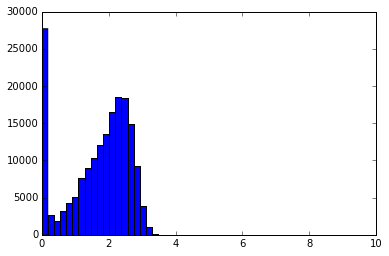

In [81]:
## Let's make a histogram to see where we should make the cut

entrynums = obj.NC_ENTRIES.copy() ## avoid tampering with the dataset unless necessary

entrynums += 1 ## add 1 to all (since we need to take log, cannot have zeros. 
               ##               this is a quick solution that does not compromise the histogram)

plt.hist(np.log10(entrynums),bins=50)
plt.show()

In [82]:
## Neat!! well, it looks like anything over a power of 4 (10,000) is an extreme outlier and most likely bad data.
##  In fact, we can look at the data and determine that anything above 5k can be dropped.
##    (closest legit data is ~3k from Grand Central)
##    this knocks out 19 readings out of about 180K (not bad)

ndf = obj[obj.NC_ENTRIES < 5000]

In [83]:
ndf.describe()

ENTRIES  \
count  1.799870e+05   
mean   3.287540e+07   
std    1.881612e+08   
min    0.000000e+00   
25%    6.427545e+05   
50%    2.656949e+06   
75%    6.413418e+06   
max    2.118720e+09   

       EXITS                                                                 \
count                                       1.799870e+05                      
mean                                        2.706409e+07                      
std                                         1.712929e+08                      
min                                         0.000000e+00                      
25%                                         3.500425e+05                      
50%                                         1.605755e+06                      
75%                                         4.654835e+06                      
max                                         2.087387e+09                      

          NC_ENTRIES       NC_EXITS  
count  179987.000000  179987.000000  
mean      184.636396     141.689589  
std       260.233661     233.219676  
min         0.000000       0.000000  
25%        12.000000       9.000000  
50%        83.000000      56.000000  
75%       257.000000     174.000000  
max      3366.000000    5197.000000

In [84]:
## we should do the same with exits, however maximum number of exits is 5197, which seems reasonable
##  let's just check to make sure it is a time/station for which that may be plausible.

ndf[ndf.NC_EXITS > 5000]

C/A  UNIT       SCP          STATION LINENAME DIVISION        DATE  \
36397  R241A  R048  00-00-00  42 ST-GRD CNTRL    4567S      IRT  08/06/2015   

           TIME     DESC   ENTRIES  \
36397  13:00:00  REGULAR  12959071   

       EXITS                                                                 \
36397                                           25997628                      

       NC_ENTRIES  NC_EXITS  
36397         230      5197

In [ ]:
## again it's grand central, this time at the morning rush hour. This makes perfect sense, so let's leave it.